In [79]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import tqdm.notebook

import sys
sys.path.insert(0, '../utils')

import te_mp

# import scipy.integrate

In [82]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

# Test run to evaluate parameters

In [3]:
# Simulation time step size (s)
dt_trial = 2e-3

# Total time per block (s)
T_max_full = 0.75
T_min_full = -0.25
T = T_max_full - T_min_full

T_min = 0
t_min_ind = int((T_min-T_min_full)/dt_trial)
T_max = 0.5
t_max_ind = int((T_max - T_min_full)/dt_trial)


# Array of time steps
t_trial = np.arange(0, int(T/dt_trial))*dt_trial + T_min_full

In [4]:
dt_mp = dt_trial
T_mp_max = 0.2

tau = np.arange(0, int(T_mp_max/dt_mp))*dt_mp

In [5]:
def cf_delay_fun(t_trial):
    delay_distr = np.exp(-(t_trial-0.12)**2/0.005**2)
    delay_distr /= np.sum(delay_distr)
    return delay_distr

cf_prob_fun = lambda retinal_slip: np.maximum(-retinal_slip, 0)

In [6]:
poisson_model_params = {
    'max_pf_rate': 0.477,
    'cf_delay_fun': cf_delay_fun,
    'exc_current_kernel':np.exp(-(t_trial - t_trial[0])/10e-3),
    'type':'poisson'
}


In [7]:
sigma2 = 0.01 # s
eligibility_window = lambda t, center: np.exp(-((t-center)/sigma2)**2)

Note that the area under the curve of the eligibility window is increasing until $\tau_\text{peak}$ is ~30 ms, as shown below. Below, we set the magnitude of LTP to approximately compensate for the amount of LTD expected given the max area under the curve. This means that the magnitude of LTP (as set below) will be larger than the expected amount of LTD for small values of $\tau_\text{peak}$, and therefore the equilibrium value of the weight will be larger.

In [58]:
centers = np.linspace(0,0.12, 5)

In [59]:
areas = np.array([np.sum(eligibility_window(tau, centers[i])) for i in range(len(centers))])

In [72]:
areas[-1]*dt_trial

np.float64(0.017724538509055157)

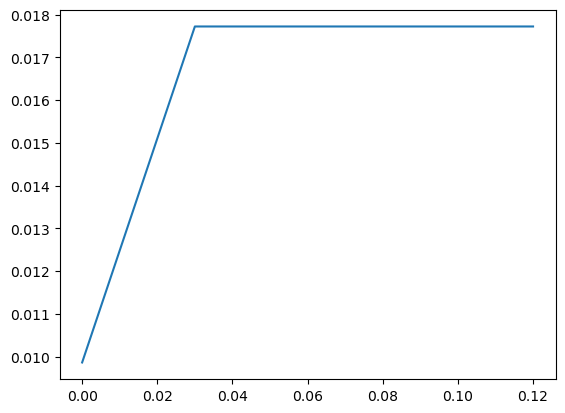

In [71]:
plt.plot(centers, areas*dt_trial)

In [8]:
tau_l = 0.02
tau_r = 0.02
dv = 5e-4
temp_rule_selection = lambda t, center: dv*np.sign(t-center)*(t >= center - tau_l)*(t<= center+tau_r)

In [76]:
eligibility_params_adj = {
    'tau_peaks': 0,
    'timer': eligibility_window,
    'temp_rule': temp_rule_selection
}

In [73]:
plasticity_params_untuned = {
    'dw_ltd': 3e-2,
    'dw_ltp': 3e-2*0.018,
    'decay_rate': 1/(1000)
}


In [11]:
hist_edges = np.linspace(0, tau[-1] + (tau[1]-tau[0]), 100+1)

In [77]:
results_adj = te_mp.simulateLearningAdjustment_TeMP(1, 10000, t_trial, cf_prob_fun, 
                                   poisson_model_params, plasticity_params_untuned, 'single', tau, 
                                   eligibility_params_adj, history_samples = 0,
                                    calculate_hist = True, hist_every = 0, rng_seed=0,
                                    PF_samples = [0], notebook_mode = True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

LTP, LTD and the decay of the weight lead to the mean weight to equilibrate at a value close to but larger than the baseline (2.5):

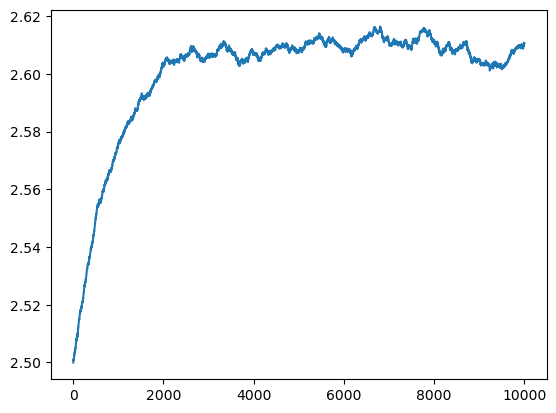

In [78]:
plt.plot(np.mean(results_adj['w_mean'],axis=0))

# Analyze results of long simulation

In [26]:
# Results of running timer-selection-integrated.py for 10 simulation blocks
# of 1,000,000 trials, and a sample interval of 1,000 trials

folder = 'files/timer-selection-integrated'

# mean weight
w_mean = np.load(folder+'/w_mean.npy')

# time of peak eligibility for 3 sample PFs through simulation
tau_peak_history = np.load(folder+'/tau_peak_history.npy')

# time of peak eligibility for all 120 PFs at the end of the simulation
tau_peaks_final = np.load(folder+'/tau_peaks.npy')

# time course of mean time of peak eligibility through simulation
tau_peaks_mean = np.load(folder+'/tau_peak_mean.npy')

# histogram of PF-CF intervals for 3 sample PFs and (index 0) for all PFs,
# cumulatively over the simulation
hist_history_final = np.load(folder+'/hist_history.npy')

In [32]:
samples = np.arange(w_mean.shape[1])

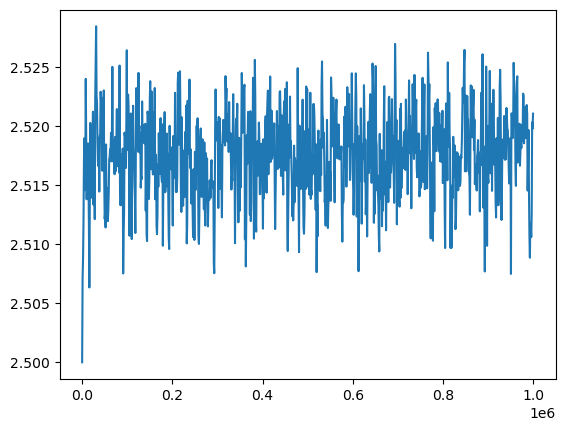

In [42]:
plt.plot(np.arange(w_mean.shape[1])*1000,w_mean[-1,:])

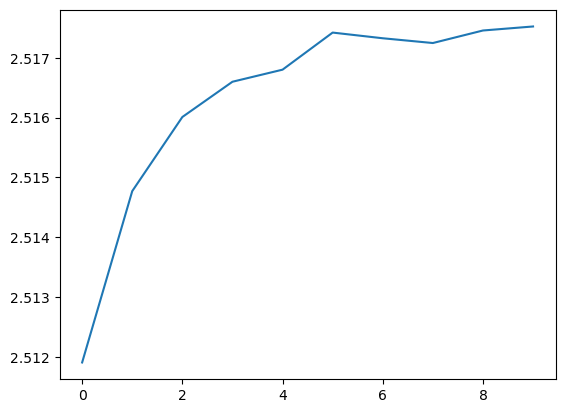

In [35]:
plt.plot(np.arange(w_mean.shape[0]), np.mean(w_mean, axis=1))

In [84]:
# Average time of peak eligibility across population, averaged over the last 100,000 trials
# of the final simulation block
tau_final_mean = np.mean(tau_peaks_mean[-1,0,-100:])
print(tau_final_mean)

0.12528387500000007


In [194]:
tau_peaks_mean_mu = tau_peaks_mean[:,0,1:].flatten()
tau_peaks_mean_std = tau_peaks_mean[:,1,1:].flatten()

In [197]:
samples = np.arange(0, len(tau_peaks_mean_mu))*1000

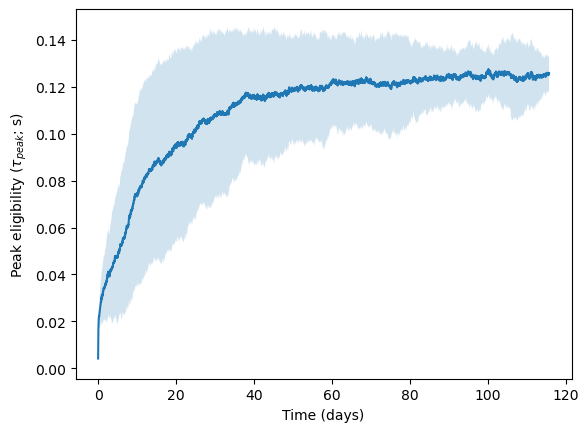

In [207]:
# Plot time course of average peak eligibility during the simulation
plt.fill_between(samples/(3600*24), tau_peaks_mean_mu - tau_peaks_mean_std, 
                 tau_peaks_mean_mu + tau_peaks_mean_std, alpha=0.2)
plt.plot(samples/(3600*24), tau_peaks_mean_mu)
plt.xlabel('Time (days)')
plt.ylabel(r'Peak eligibility ($\tau_{peak}$; s)');

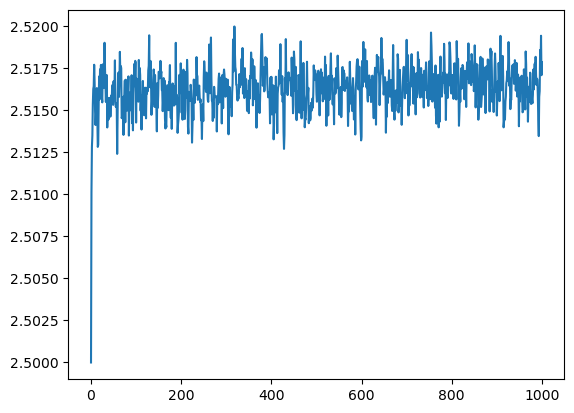

In [204]:
# Mean weight
plt.plot(np.mean(w_mean, axis=0))

## Evaluate PF-CF interval distribution

In [69]:
hist_edges = np.linspace(0, tau[-1] + (tau[1]-tau[0]), 100+1)

<BarContainer object of 100 artists>

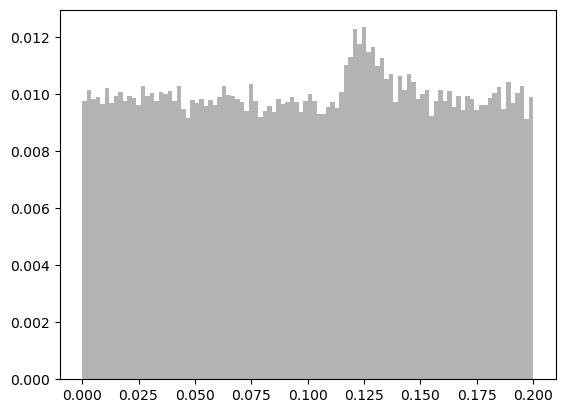

In [73]:
# for one of the sample PFs
pf_sample_ind = 1
plt.bar(hist_edges[:-1], hist_history_final[pf_sample_ind,:]/np.sum(hist_history_final[pf_sample_ind,:]), hist_edges[1],
        align='edge', facecolor=(0.7,)*3)

In [214]:
np.save('files/timer-adjustment-integrated-hist.npy', hist_history_final[1,:]/np.sum(hist_history_final[1,:]))

# For Figure 4

In [80]:
empirical_pdf = hist_history_final[1,:]/np.sum(hist_history_final[1,:])

(0.0, 1.0)

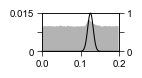

In [85]:
plt.figure(figsize=(1,0.5))

ax = plt.gca()

ax2 = plt.twinx()
ax.fill_between(tau, empirical_pdf, facecolor=(0.7,)*3)
ax.set_yticks([0,0.0075,0.015],[0,'',0.015])
ax.set_ylim([0, 0.015])
ax.set_xlim([0, 0.2])

ax2.plot(tau, eligibility_window(tau, tau_final_mean),c='k',lw=0.75,clip_on=False)
ax2.set_yticks([0,0.5,1],[0,'',1])
ax2.set_ylim([0,1])
# plt.savefig('figures/timer-adjustment-integrated.pdf')

### Dynamics

In [90]:
median_window = lambda t, t_peak: np.sign(t-t_peak)
narrow_window = lambda t, t_peak, hw: median_window(t,t_peak)*(t <= t_peak+hw)*(t>= t_peak-hw)

To calculate the expected change in $\tau_\text{peak}$, we can take the cross-correlation of the narrow window at every value of $\tau_\text{peak}$ with the distribution:

In [94]:
T_width = int(T_mp_max/dt_mp) # width of listening window (time steps)

window_width = 1e-2 # width of each lobe (s)
T_width_offset = int(window_width/dt_mp) # in time steps

In [159]:
mean_delta_tp = dt_mp*np.correlate(empirical_pdf, narrow_window(tau[:T_width_offset*2+1], window_width, window_width),mode='full')[T_width_offset:-T_width_offset]

Correctly normalized (by multiplication times timestep)

([<matplotlib.axis.XTick at 0x15310cf50>,
 [Text(0.0, 0, '0.0'), Text(0.1, 0, '0.1'), Text(0.2, 0, '0.2')])

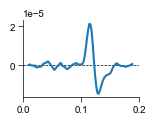

In [160]:
plt.figure(figsize=(1.5,1))
plt.plot([0, 0.2], [0,0],ls='--',c='k',lw=0.5)
plt.plot(tau[T_width_offset:-T_width_offset], mean_delta_tp[T_width_offset:-T_width_offset])
plt.xlim([0, 0.2])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([0, 0.1, 0.2])
# plt.ylim([-0.025,0.025])
# plt.yticks([-0.025,0,0.025]);

# plt.savefig('figures/single-timer-dynamics-empirical.pdf')

Version plotted in current text:

In [134]:
dt_plot = 1e-3
tau_plot = np.arange(0, int(T_mp_max/dt_plot))*dt_plot

T_width_plot = int(T_mp_max/dt_plot) # width of listening window (time steps)

window_width = 1e-2 # width of each lobe (s)
T_width_offset_plot = int(window_width/dt_plot) # in time steps

In [132]:
empirical_pdf_plot = np.interp(tau_plot, tau, empirical_pdf)

In [152]:
mean_delta_tp_plot = np.correlate(empirical_pdf_plot, 
                                  narrow_window(tau_plot[:T_width_offset_plot*2+1], 
                                                window_width, window_width),mode='full')[T_width_offset_plot:-T_width_offset_plot]

In [153]:
mean_delta_tp_plot.shape

(200,)

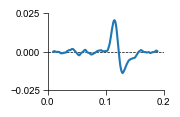

In [156]:
plt.figure(figsize=(1.5,1))
plt.plot([0, 0.2], [0,0],ls='--',c='k',lw=0.5)
plt.plot(tau_plot[T_width_offset_plot:-T_width_offset_plot], mean_delta_tp_plot[T_width_offset_plot:-T_width_offset_plot])
plt.xlim([0, 0.2])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([0, 0.1, 0.2])
plt.ylim([-0.025,0.025])
plt.yticks([-0.025,0,0.025]);

# plt.savefig('figures/single-timer-dynamics-empirical.pdf')